## Importing necessary libraries

In [ ]:
import tensorflow as tf
import numpy as np
import re, os
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

## Getting data from Kaggle

In [ ]:
import requests
import pandas as pd
import tarfile
import os

# Define the URL for the IMDb sentiment analysis dataset
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset_filename = "aclImdb_v1.tar.gz"

# Specify the download location
download_location = "./data/"

# Create the download directory if it doesn't exist
if not os.path.exists(download_location):
    os.makedirs(download_location)

# Download the dataset
response = requests.get(url)
with open(download_location + dataset_filename, 'wb') as f:
    f.write(response.content)

# Extract the downloaded file
with tarfile.open(download_location + dataset_filename, 'r:gz') as tar:
    tar.extractall(download_location)

# Define the path to the extracted dataset
dataset_path = download_location + "aclImdb/"

# Function to load the dataset into a Pandas DataFrame
def load_imdb_dataset(data_path):
    texts = []
    labels = []
    for category in ['train', 'test']:
        for sentiment in ['pos', 'neg']:
            folder_path = os.path.join(data_path, category, sentiment)
            for filename in os.listdir(folder_path):
                with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
                    text = file.read()
                    texts.append(text)
                    labels.append(1 if sentiment == 'pos' else 0)
    return pd.DataFrame({'text': texts, 'label': labels})

# Load the dataset into a Pandas DataFrame
imdb_df = load_imdb_dataset(dataset_path)

# Display the first few rows of the DataFrame
print(imdb_df.head())


                                                text  label
0  I'm intrigued by the strong sense of favour to...      1
1  The best film on the battle of San Antonio, Te...      1
2  This is how i felt while watching this film. I...      1
3  While not as famous as some of their other col...      1
4  Unlike many other films, which are disturbing ...      1


In [ ]:
len(imdb_df)

50000

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into train, test, and validation sets
df_train, test_val_df = train_test_split(imdb_df, test_size=20000, random_state=42)
df_test, df_val = train_test_split(test_val_df, test_size=0.2, random_state=42)

# Display the shapes of the resulting DataFrames
print("Train set shape:", df_train.shape)
print("Test set shape:", df_test.shape)
print("Validation set shape:", df_val.shape)


Train set shape: (30000, 2)
Test set shape: (16000, 2)
Validation set shape: (4000, 2)


In [ ]:
df_val.head()

,text,label
26891,The film is a remake of a 1956 BBC serial call...,1
25024,"During World War II, two Byelorussian (Soviet ...",1
11666,The information contained in this movie is som...,1
40303,and I have seen a lot of films. I saw this in ...,0
18010,This su*k! Why do they have to make movies tha...,0


In [ ]:
df_test.head()

,text,label
24835,"As usual, on IMDb, going by the majority vote ...",0
28073,Spoilers in this review! Despite a few highly ...,1
31069,I think this movie is the most misunderstood f...,1
25736,This film is excellent! Fear of watching docum...,1
40229,At the least some of the sitcoms that churn en...,0


In [ ]:
df_train['label'].value_counts()

0    15084
1    14916
Name: label, dtype: int64

## Preprocessing

In [ ]:
# Cleaning/Preprocessing Helper function

def preprocess(s):
  s = re.sub(r'@[a-zA-Z0-9_.]+ ', '', str(s))
  s = re.sub(r'#[a-zA-Z0-9_.]+ ', '', str(s))
  s = re.sub(r'''[^a-zA-Z0-9?. ]+''', '', s)
  s = re.sub(r''''[' ']+''', " ", s)
  s = re.sub(r'(\w)\1{2,}',r'\1',s)
  s = s.lower().strip()
  return s

In [ ]:
df_train['text'] = df_train['text'].apply(preprocess)
df_val['text'] = df_val['text'].apply(preprocess)
df_test['text'] = df_test['text'].apply(preprocess)

In [ ]:
def get_data(df):
  zeros, ones = df[df['label']==0], df[df['label']==1]
  zero_text, zero_labels = zeros['text'].to_numpy(), zeros['label'].to_numpy()
  one_text, one_labels = ones['text'].to_numpy(), ones['label'].to_numpy()
  X, Y = np.concatenate((one_text,zero_text)), np.concatenate((one_labels,zero_labels))
  return X,Y

In [ ]:
X_train,Y_train = get_data(df_train)
X_val,Y_val = get_data(df_val)
X_test,Y_test = get_data(df_test)

In [ ]:
X_train.shape,X_val.shape,X_test.shape

((30000,), (4000,), (16000,))

## Creating the Model

In [ ]:
# Instantiating the Tokenizer and creating sequences
tokenizer = tf.keras.preprocessing.text.Tokenizer(3000,oov_token=1)
tokenizer.fit_on_texts(X_train)
train_seq = tokenizer.texts_to_sequences(X_train)
val_seq = tokenizer.texts_to_sequences(X_val)
test_seq = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Padding all sequences
train_seq = tf.keras.preprocessing.sequence.pad_sequences(train_seq,maxlen=50,padding='post')
val_seq = tf.keras.preprocessing.sequence.pad_sequences(val_seq,maxlen=50,padding='post')
test_seq = tf.keras.preprocessing.sequence.pad_sequences(test_seq,maxlen=50,padding='post')

## Creating the Model

In [ ]:
# from tensorflow.keras.layers import Embedding,Dense,LSTM,Flatten,Dropout
# def create_model():
#   model = tf.keras.models.Sequential()
#   model.add(Embedding(3000,64))
#   model.add(LSTM(32))
#   model.add(Flatten())
#   model.add(Dense(64,activation='relu'))
#   model.add(Dropout(0.3))
#   model.add(Dense(32,activation='relu'))
#   model.add(Dropout(0.3))
#   model.add(Dense(4,activation='relu'))
#   model.add(Dense(1,activation='sigmoid'))
#   model.summary()
#   model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
#   return model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Conv1D, MaxPooling1D, Bidirectional, GlobalMaxPooling1D, Dense, Dropout

def create_model():
    model = tf.keras.models.Sequential()
    model.add(Embedding(input_dim=3000, output_dim=128))

    # Convolutional layers
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(units=64, return_sequences=True)))

    # Global Max Pooling layer
    model.add(GlobalMaxPooling1D())

    # Dense layers
    model.add(Dense(units=256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(units=1, activation='sigmoid'))

    model.summary()

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model


## Full Model Training

In [ ]:
# HELPER FUNCTION

def plot(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['train_loss','val_loss'])
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.legend(['train_accuracy','val_accuracy'])
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()

In [ ]:
def train_full_model(train_seq,Y_train,val_seq,Y_val,test_seq,Y_test):
  model = create_model()
  history = model.fit(train_seq,Y_train,256,15,validation_data=(val_seq,Y_val),callbacks=[tf.keras.callbacks.ModelCheckpoint('FullModelCheckpoint.h5',save_best_only=True,verbose=1),tf.keras.callbacks.EarlyStopping(patience=6,verbose=1)])
  plot(history)
  model = tf.keras.models.load_model('FullModelCheckpoint.h5')
  print(model.evaluate(test_seq,Y_test))
  return model

## Active Learning

In [ ]:
# HELPER FUNCTIONS

def append_history(losses,val_losses,acc,val_acc,history):
  losses = losses + history.history['loss']
  val_losses = val_losses + history.history['val_loss']
  acc = acc + history.history['accuracy']
  val_acc = val_acc + history.history['val_accuracy']
  return losses,val_losses,acc,val_acc

def plot_merged_metrics(losses,val_losses,accuracies,val_accuracies):
  plt.plot(losses)
  plt.plot(val_losses)
  plt.legend(['train_loss','val_loss'])
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

  plt.plot(accuracies)
  plt.plot(val_accuracies)
  plt.legend(['train_accuracy','val_accuracy'])
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.cluster import KMeans

# Set a random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

def diversity_sampling(model, pool_features, pool_labels, sampling_size=2000, num_clusters=5):
    # Get the penultimate layer activations as features for diversity calculation
    penultimate_layer_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
    features = penultimate_layer_model.predict(pool_features)

    # Apply k-means clustering to the penultimate layer features
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_assignments = kmeans.fit_predict(features)

    # Calculate the diversity scores for each sample in the pool
    diversity_scores = []
    for i in range(pool_features.shape[0]):
        cluster_distance = np.min(np.linalg.norm(features[i] - kmeans.cluster_centers_, axis=1))
        diversity_scores.append(cluster_distance)

    # Select samples with high diversity
    sample_indices = np.argsort(diversity_scores)[-sampling_size:]

    # Convert sample_indices to an array of integers
    sample_indices = np.array(sample_indices, dtype=np.int32)

    # Use boolean indexing to get the selected labels
    selected_labels = pool_labels[sample_indices]
    selected_samples = pool_features[sample_indices]

    return selected_samples, selected_labels


def train_small_models(train_features, train_labels, pool_features, pool_labels, val_seq, Y_val, test_seq, Y_test, iters=3, sampling_size=2000):
    losses, val_losses, accuracies, val_accuracies = [], [], [], []

    for iter_n in range(iters):
        # Create a new model for each iteration
        model = create_model()
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        checkpoint = tf.keras.callbacks.ModelCheckpoint(f'Checkpoint_{iter_n}.h5', save_best_only=True, verbose=1)

        print(f"Starting to train with {train_features.shape[0]} labeled samples")

        history = model.fit(train_features, train_labels, batch_size=256, epochs=15,
                            validation_data=(val_seq, Y_val),
                            callbacks=[checkpoint],
                            shuffle=True)  # Ensure training data shuffling for randomness

        losses, val_losses, accuracies, val_accuracies = append_history(losses, val_losses, accuracies, val_accuracies, history)

        # Evaluate and print accuracy on test data
        test_accuracy = model.evaluate(test_seq, Y_test)[1]
        print(f"Accuracy on test data after iteration {iter_n}: {test_accuracy}, Number of labeled samples: {train_features.shape[0]}")

        # Use diversity sampling to select samples from the pool
        selected_samples, selected_labels = diversity_sampling(model, pool_features, pool_labels, sampling_size)

        # Remove the chosen samples from the pool
        pool_features = np.delete(pool_features, selected_samples, axis=0)
        pool_labels = np.delete(pool_labels, selected_samples)

        # Add the sampled entries to the original data
        train_features = np.vstack((train_features, selected_samples))
        train_labels = np.hstack((train_labels, selected_labels))

    plot_merged_metrics(losses, val_losses, accuracies, val_accuracies)

    return model


## Ensembling

In [ ]:
# # Splitting Data into Oracle Set(Unlabelled set) and Original Training set
import sklearn.model_selection
train_features,pool_features,train_labels,pool_labels = sklearn.model_selection.train_test_split(train_seq,Y_train,test_size=29000,stratify=Y_train)
train_features.shape,pool_features.shape

((1000, 50), (29000, 50))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 128)         384000    
                                                                 
 conv1d_8 (Conv1D)           (None, None, 128)         49280     
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, None, 128)         0         
 g1D)                                                            
                                                                 
 bidirectional_8 (Bidirecti  (None, None, 128)         98816     
 onal)                                                           
                                                                 
 global_max_pooling1d_8 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.6917 - accuracy: 0.5250
Epoch 2: val_loss improved from 0.69315 to 0.69312, saving model to Checkpoint_0.h5
4/4 [==============================] - 2s 644ms/step - loss: 0.6917 - accuracy: 0.5250 - val_loss: 0.6931 - val_accuracy: 0.4900
Epoch 3/15
4/4 [==============================] - ETA: 0s - loss: 0.6942 - accuracy: 0.4970
Epoch 3: val_loss improved from 0.69312 to 0.69296, saving model to Checkpoint_0.h5
4/4 [==============================] - 2s 663ms/step - loss: 0.6942 - accuracy: 0.4970 - val_loss: 0.6930 - val_accuracy: 0.5433
Epoch 4/15
4/4 [==============================] - ETA: 0s - loss: 0.6939 - accuracy: 0.4780
Epoch 4: val_loss improved from 0.69296 to 0.69279, saving model to Checkpoint_0.h5
4/4 [==============================] - 2s 655ms/step - loss: 0.6939 - accuracy: 0.4780 - val_loss: 0.6928 - val_accuracy: 0.5472
Epoch 5/15
4/4 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.5150
Epoc

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 128)         384000    
                                                                 
 conv1d_9 (Conv1D)           (None, None, 128)         49280     
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, None, 128)         0         
 g1D)                                                            
                                                                 
 bidirectional_9 (Bidirecti  (None, None, 128)         98816     
 onal)                                                           
                                                                 
 global_max_pooling1d_9 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - ETA: 0s - loss: 0.6769 - accuracy: 0.6030
Epoch 2: val_loss improved from 0.70607 to 0.70017, saving model to Checkpoint_1.h5
8/8 [==============================] - 3s 398ms/step - loss: 0.6769 - accuracy: 0.6030 - val_loss: 0.7002 - val_accuracy: 0.5132
Epoch 3/15
8/8 [==============================] - ETA: 0s - loss: 0.6628 - accuracy: 0.6025
Epoch 3: val_loss did not improve from 0.70017
8/8 [==============================] - 4s 577ms/step - loss: 0.6628 - accuracy: 0.6025 - val_loss: 0.7003 - val_accuracy: 0.5132
Epoch 4/15
8/8 [==============================] - ETA: 0s - loss: 0.6341 - accuracy: 0.6030
Epoch 4: val_loss improved from 0.70017 to 0.66464, saving model to Checkpoint_1.h5
8/8 [==============================] - 3s 395ms/step - loss: 0.6341 - accuracy: 0.6030 - val_loss: 0.6646 - val_accuracy: 0.5132
Epoch 5/15
8/8 [==============================] - ETA: 0s - loss: 0.5325 - accuracy: 0.6240
Epoch 5: val_loss improved from 0.66464 t

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 128)         384000    
                                                                 
 conv1d_10 (Conv1D)          (None, None, 128)         49280     
                                                                 
 max_pooling1d_10 (MaxPooli  (None, None, 128)         0         
 ng1D)                                                           
                                                                 
 bidirectional_10 (Bidirect  (None, None, 128)         98816     
 ional)                                                          
                                                                 
 global_max_pooling1d_10 (G  (None, 128)               0         
 lobalMaxPooling1D)                                              
                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - ETA: 0s - loss: 0.6791 - accuracy: 0.5743
Epoch 2: val_loss did not improve from 0.69848
12/12 [==============================] - 4s 306ms/step - loss: 0.6791 - accuracy: 0.5743 - val_loss: 0.6993 - val_accuracy: 0.5132
Epoch 3/15
12/12 [==============================] - ETA: 0s - loss: 0.6544 - accuracy: 0.5760
Epoch 3: val_loss improved from 0.69848 to 0.66312, saving model to Checkpoint_2.h5
12/12 [==============================] - 5s 463ms/step - loss: 0.6544 - accuracy: 0.5760 - val_loss: 0.6631 - val_accuracy: 0.5132
Epoch 4/15
12/12 [==============================] - ETA: 0s - loss: 0.5060 - accuracy: 0.6867
Epoch 4: val_loss improved from 0.66312 to 0.64133, saving model to Checkpoint_2.h5
12/12 [==============================] - 4s 331ms/step - loss: 0.5060 - accuracy: 0.6867 - val_loss: 0.6413 - val_accuracy: 0.7303
Epoch 5/15
12/12 [==============================] - ETA: 0s - loss: 0.3037 - accuracy: 0.8930
Epoch 5: val_loss improved 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 128)         384000    
                                                                 
 conv1d_11 (Conv1D)          (None, None, 128)         49280     
                                                                 
 max_pooling1d_11 (MaxPooli  (None, None, 128)         0         
 ng1D)                                                           
                                                                 
 bidirectional_11 (Bidirect  (None, None, 128)         98816     
 ional)                                                          
                                                                 
 global_max_pooling1d_11 (G  (None, 128)               0         
 lobalMaxPooling1D)                                              
                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - ETA: 0s - loss: 0.6703 - accuracy: 0.5732
Epoch 2: val_loss improved from 0.69947 to 0.68965, saving model to Checkpoint_3.h5
16/16 [==============================] - 6s 373ms/step - loss: 0.6703 - accuracy: 0.5732 - val_loss: 0.6897 - val_accuracy: 0.5132
Epoch 3/15
16/16 [==============================] - ETA: 0s - loss: 0.4861 - accuracy: 0.7400
Epoch 3: val_loss improved from 0.68965 to 0.66409, saving model to Checkpoint_3.h5
16/16 [==============================] - 6s 417ms/step - loss: 0.4861 - accuracy: 0.7400 - val_loss: 0.6641 - val_accuracy: 0.7393
Epoch 4/15
16/16 [==============================] - ETA: 0s - loss: 0.2695 - accuracy: 0.8985
Epoch 4: val_loss improved from 0.66409 to 0.54843, saving model to Checkpoint_3.h5
16/16 [==============================] - 5s 352ms/step - loss: 0.2695 - accuracy: 0.8985 - val_loss: 0.5484 - val_accuracy: 0.7530
Epoch 5/15
16/16 [==============================] - ETA: 0s - loss: 0.1760 - accurac

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, None, 128)         384000    
                                                                 
 conv1d_12 (Conv1D)          (None, None, 128)         49280     
                                                                 
 max_pooling1d_12 (MaxPooli  (None, None, 128)         0         
 ng1D)                                                           
                                                                 
 bidirectional_12 (Bidirect  (None, None, 128)         98816     
 ional)                                                          
                                                                 
 global_max_pooling1d_12 (G  (None, 128)               0         
 lobalMaxPooling1D)                                              
                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - ETA: 0s - loss: 0.6459 - accuracy: 0.5758
Epoch 2: val_loss improved from 0.69352 to 0.63692, saving model to Checkpoint_4.h5
20/20 [==============================] - 7s 355ms/step - loss: 0.6459 - accuracy: 0.5758 - val_loss: 0.6369 - val_accuracy: 0.5495
Epoch 3/15
20/20 [==============================] - ETA: 0s - loss: 0.4051 - accuracy: 0.8126
Epoch 3: val_loss improved from 0.63692 to 0.61525, saving model to Checkpoint_4.h5
20/20 [==============================] - 7s 356ms/step - loss: 0.4051 - accuracy: 0.8126 - val_loss: 0.6152 - val_accuracy: 0.7235
Epoch 4/15
20/20 [==============================] - ETA: 0s - loss: 0.2317 - accuracy: 0.9156
Epoch 4: val_loss improved from 0.61525 to 0.54871, saving model to Checkpoint_4.h5
20/20 [==============================] - 7s 346ms/step - loss: 0.2317 - accuracy: 0.9156 - val_loss: 0.5487 - val_accuracy: 0.7560
Epoch 5/15
20/20 [==============================] - ETA: 0s - loss: 0.1473 - accurac

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


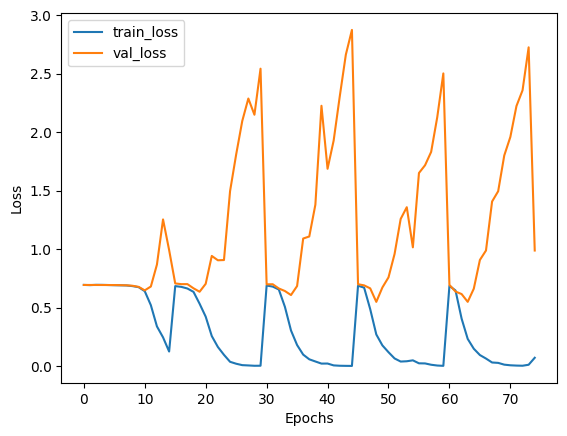

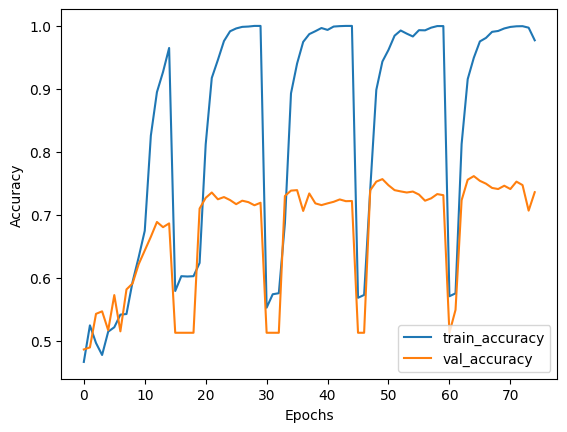

In [ ]:
# Training 3 Active Learning Models for Ensembling
al_model1 = train_small_models(train_features,train_labels,pool_features,pool_labels,val_seq,Y_val,test_seq,Y_test,iters=5, sampling_size=1000)
# al_model2 = train_small_models(train_features,train_labels,pool_features,pool_labels,val_seq,Y_val,test_seq,Y_test)
# al_model3 = train_small_models(train_features,train_labels,pool_features,pool_labels,val_seq,Y_val,test_seq,Y_test)